# __The Engle-Granger Procedure (Julia)__

<br>

Finance 5330: Financial Econometrics <br>
Tyler J. Brough <br>
Last Update: March 19, 2020 <br>
<br>

In [1]:
using CSV
using DataFrames
using HypothesisTests
using GLM
using PyPlot; const plt = PyPlot;

## Heating Oil Spot and Futures Historical Data

In [2]:
ho_spot = CSV.read("./data/HO-Spot.csv");

In [3]:
first(ho_spot, 5)

,Date,HO-Spot
,Dates…,Float64
1,2020-02-25,1.529
2,2020-02-24,1.575
3,2020-02-21,1.65
4,2020-02-20,1.657
5,2020-02-19,1.667


In [4]:
last(ho_spot, 5)

,Date,HO-Spot
,Dates…,Float64
1,1986-06-06,0.385
2,1986-06-05,0.39
3,1986-06-04,0.378
4,1986-06-03,0.393
5,1986-06-02,0.402


In [5]:
ho_fut = CSV.read("./data/HO-Futures.csv");

In [6]:
first(ho_fut, 5)

,Date,HO-Futures
,Dates…,Float64
1,2020-03-03,1.533
2,2020-03-02,1.529
3,2020-02-28,1.491
4,2020-02-27,1.489
5,2020-02-26,1.499


In [7]:
last(ho_fut, 5)

,Date,HO-Futures
,Dates…,Float64
1,1980-01-08,0.786
2,1980-01-07,0.828
3,1980-01-04,0.85
4,1980-01-03,0.827
5,1980-01-02,0.821


In [8]:
ho = DataFrames.join(ho_spot, ho_fut, on = :Date);
sort!(ho, :Date);
ho = ho[910:1899,:];

In [9]:
first(ho, 10)

,Date,HO-Spot,HO-Futures
,Dates…,Float64,Float64
1,1990-01-18,0.651,0.618
2,1990-01-19,0.647,0.637
3,1990-01-22,0.628,0.61
4,1990-01-23,0.602,0.593
5,1990-01-24,0.611,0.596
6,1990-01-25,0.61,0.598
7,1990-01-26,0.605,0.596
8,1990-01-29,0.615,0.611
9,1990-01-30,0.596,0.605


In [10]:
last(ho, 10)

,Date,HO-Spot,HO-Futures
,Dates…,Float64,Float64
1,1993-12-16,0.436,0.446
2,1993-12-17,0.43,0.441
3,1993-12-20,0.429,0.438
4,1993-12-21,0.426,0.434
5,1993-12-22,0.431,0.44
6,1993-12-23,0.434,0.442
7,1993-12-27,0.442,0.443
8,1993-12-28,0.437,0.436
9,1993-12-29,0.449,0.448


In [12]:
rename!(ho, ["Date", "Spot", "Futures"]);

In [13]:
first(ho, 5)

,Date,Spot,Futures
,Dates…,Float64,Float64
1,1990-01-18,0.651,0.618
2,1990-01-19,0.647,0.637
3,1990-01-22,0.628,0.61
4,1990-01-23,0.602,0.593
5,1990-01-24,0.611,0.596


In [14]:
S = Vector((ho.Spot));
F = Vector((ho.Futures));
lnS = Vector(log.(ho.Spot));
lnF = Vector(log.(ho.Futures));

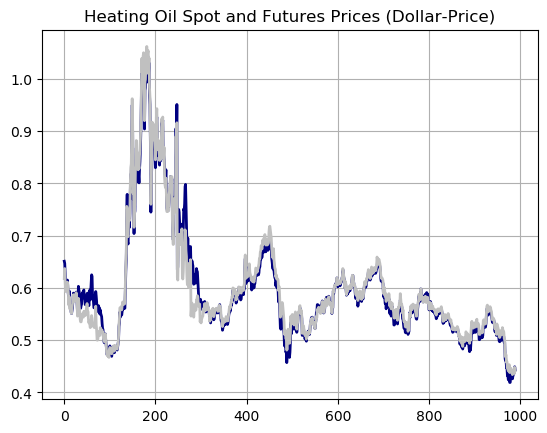

In [15]:
plt.plot(S, color="navy", linewidth=2);
plt.plot(F, color="silver", linewidth=2);
plt.title("Heating Oil Spot and Futures Prices (Dollar-Price)");
plt.grid(true);

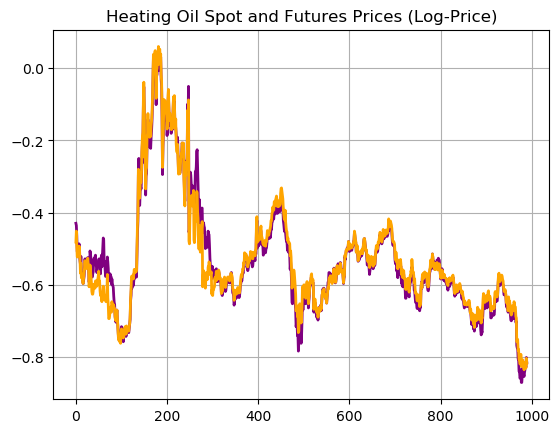

In [16]:
plt.plot(lnS, color="purple", linewidth=2);
plt.plot(lnF, color="orange", linewidth=2);
plt.title("Heating Oil Spot and Futures Prices (Log-Price)");
plt.grid(true);

### ADF Test on Log-Level Prices

In [17]:
test1 = ADFTest(lnS, :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.00039240887127047

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.5955

Details:
    sample size in regression:          988
    number of lags:                     1
    ADF statistic:                      -0.24921415432742372
    Critical values at 1%, 5%, and 10%: [-2.5680020844811757 -1.9412747142757028 -1.6165544601365147]


In [18]:
pvalue(test1)

0.5954874845931206

In [19]:
test2 = ADFTest(lnF, :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.0003666276317198039

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.6008

Details:
    sample size in regression:          988
    number of lags:                     1
    ADF statistic:                      -0.23500747932560567
    Critical values at 1%, 5%, and 10%: [-2.5680020844811757 -1.9412747142757028 -1.6165544601365147]


In [20]:
pvalue(test2)

0.6008467576608663

### ADF Test on Log-Price First Differences

In [21]:
DlnS = diff(lnS);
DlnF = diff(lnF);

In [22]:
test3 = ADFTest(DlnS, :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.0347941462412125

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          987
    number of lags:                     1
    ADF statistic:                      -22.692488893977604
    Critical values at 1%, 5%, and 10%: [-2.5680043754709283 -1.9412749954552933 -1.6165541943930175]


In [23]:
pvalue(test3)

0.0

In [24]:
test4 = ADFTest(DlnF, :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.027585723754591

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size in regression:          987
    number of lags:                     1
    ADF statistic:                      -22.446988716773074
    Critical values at 1%, 5%, and 10%: [-2.5680043754709283 -1.9412749954552933 -1.6165541943930175]


In [25]:
pvalue(test4)

0.0

## The Engle-Granger Procedure

### Step 1: The Cointegration Regression

In [26]:
data = DataFrame(Y=lnF, X=lnS);
reg = GLM.lm(@formula(Y ~ X), data);
z = residuals(reg);

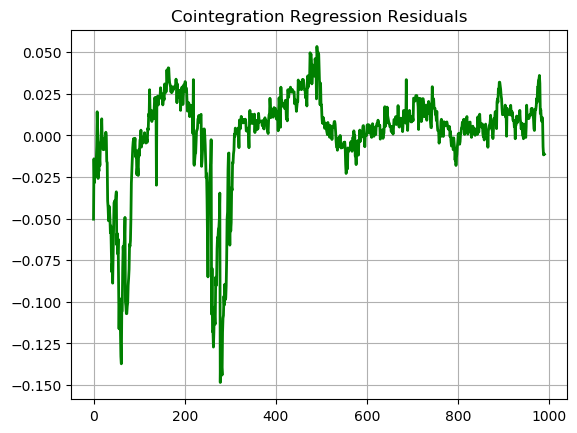

In [27]:
plt.plot(z, color="green", linewidth=2)
plt.title("Cointegration Regression Residuals")
plt.grid(true)

In [28]:
test5 = ADFTest(z, :none, 1)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.03602736494260947

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     0.0001

Details:
    sample size in regression:          988
    number of lags:                     1
    ADF statistic:                      -3.8580735280546206
    Critical values at 1%, 5%, and 10%: [-2.5680020844811757 -1.9412747142757028 -1.6165544601365147]


In [29]:
pvalue(test5)

0.00012737880669747213

<br>

We will use these residuals in the second step in the error-correction model.

<br>

### Step 2: The Error-Correction Form

In [31]:
data = DataFrame([lead(DlnS), lead(DlnF), lag(DlnS), lag(DlnF), lag(z[2:end])], 
                 [:DlnSLead, :DlnFLead, :DlnSLag, :DlnFLag, :ResidsLag]);

In [32]:
first(data, 10)

,DlnSLead,DlnFLead,DlnSLag,DlnFLag,ResidsLag
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,-0.0298061,-0.0433107,missing,missing,missing
2,-0.0422827,-0.0282646,-0.00616335,0.0302812,-0.0140946
3,0.0148395,0.00504627,-0.0298061,-0.0433107,-0.0284294
4,-0.001638,0.00335009,-0.0422827,-0.0282646,-0.015589
5,-0.0082305,-0.00335009,0.0148395,0.00504627,-0.0249689
6,0.0163938,0.0248563,-0.001638,0.00335009,-0.0200264
7,-0.0313816,-0.0098685,-0.0082305,-0.00335009,-0.0153753
8,-0.0152158,-0.0268023,0.0163938,0.0248563,-0.00645613
9,-0.0102741,-0.0380669,-0.0313816,-0.0098685,0.0141828


In [33]:
last(data, 10)

,DlnSLead,DlnFLead,DlnSLag,DlnFLag,ResidsLag
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,-0.013857,-0.0112741,0.0189131,0.0135749,0.031197
2,-0.00232829,-0.00682597,0.0208582,0.00224467,0.0131645
3,-0.00701757,-0.00917438,-0.013857,-0.0112741,0.0153614
4,0.0116687,0.0137302,-0.00232829,-0.00682597,0.0107989
5,0.00693644,0.00453516,-0.00701757,-0.00917438,0.00844662
6,0.0182653,0.00225989,0.0116687,0.0137302,0.0108331
7,-0.0113767,-0.0159275,0.00693644,0.00453516,0.00862502
8,0.0270897,0.027151,0.0182653,0.00225989,-0.00687166
9,-0.0134531,-0.0134834,-0.0113767,-0.0159275,-0.0117394


In [35]:
reg = GLM.lm(@formula(DlnSLead ~ DlnSLag + ResidsLag), dropmissing!(data))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

DlnSLead ~ 1 + DlnSLag + ResidsLag

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                 Estimate   Std. Error    t value  Pr(>|t|)    Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.000360321  0.000872331  -0.413055    0.6797  -0.00207216  0.00135152
DlnSLag      -0.00963846   0.0318555    -0.302568    0.7623  -0.0721509   0.052874  
ResidsLag     0.0388931    0.0282512     1.37669     0.1689  -0.0165463   0.0943326 
────────────────────────────────────────────────────────────────────────────────────

### The Vector Error-Correction Form

In [36]:
reg1 = GLM.lm(@formula(DlnSLead ~ DlnSLag + DlnFLag + ResidsLag), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

DlnSLead ~ 1 + DlnSLag + DlnFLag + ResidsLag

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                 Estimate   Std. Error    t value  Pr(>|t|)    Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.000358962  0.000872501  -0.411417    0.6809  -0.00207114  0.00135322
DlnSLag       0.0600715    0.094126      0.638203    0.5235  -0.12464     0.244783  
DlnFLag      -0.0750969    0.0954137    -0.787066    0.4314  -0.262335    0.112141  
ResidsLag     0.0422845    0.0285833     1.47934     0.1394  -0.0138068   0.0983757 
────────────────────────────────────────────────────────────────────────────────────

In [38]:
reg2 = GLM.lm(@formula(DlnFLead ~ DlnSLag + DlnFLag + ResidsLag), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

DlnFLead ~ 1 + DlnSLag + DlnFLag + ResidsLag

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                 Estimate   Std. Error     t value  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.000325794  0.000862695  -0.377647     0.7058  -0.00201873  0.00136714
DlnSLag      -0.00826409   0.0930681    -0.0887961    0.9293  -0.190899    0.174371  
DlnFLag       0.0134498    0.0943414     0.142565     0.8867  -0.171684    0.198583  
ResidsLag     0.0111184    0.028262      0.393404     0.6941  -0.0443424   0.0665792 
─────────────────────────────────────────────────────────────────────────────────────